# Logistic Model

## [Models in Population Biology](http://modelspopbiol.yoavram.com)
## Yoav Ram

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import logit, expit
import scipy.optimize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import pandas as pd
import seaborn as sns
blue, green, red = sns.color_palette('muted', 3)
sns.set_style('ticks')
sns.set_context('talk')

import warnings
warnings.simplefilter('ignore', UserWarning)

In the previous section we used one feature with integer values to predict another integer value.
What if we want to predict a category or class (i.e. classify or categorize) instead of predicting a number?

There are many ways to classify data (even without a training set), and one of the most common is **logistic regression**. 
But *regression* is usually used for predicting real numbers, how is regression related to classification?
In logistic regression we are trying to regress (predict a real number) the probability of some data being in a one class and not the other. 
Logistic regression is binomial (two classes, one free variable) but it can easily be expanded to *multinomial logistic regression*, sometimes also known as *softmax regression*.

# COVID-19 fatality data

This dataset includes COVID-19 case details for over 7,500 patients from Singapore, Hong Kong, Philippines, and South Korea. 
Details include age, sex, nationality, status, and dates.

Data obtained from [dolthub](https://www.dolthub.com/repositories/Liquidata/corona-virus/doc/master/README.md).

In [2]:
df = pd.read_csv("../data/covid-19_case_details.csv")
df.head()

,source,case_id,case_name,age,sex,nationality,current_status,symptomatic_date,confirmed_date,recovered_date,place_id,province_state,country_region,latitude,longitude
0,https://coronavirus-ph-api.now.sh/cases,1,NaN,38.0,F,Chinese,Recovered,NaN,2020-01-30 00:00:00,NaN,48,NaN,Philippines,13.0,122.0
1,https://coronavirus-ph-api.now.sh/cases,2,NaN,44.0,M,Chinese,Died,NaN,2020-02-02 00:00:00,NaN,48,NaN,Philippines,13.0,122.0
2,https://coronavirus-ph-api.now.sh/cases,3,NaN,60.0,F,Chinese,Recovered,NaN,2020-02-05 00:00:00,NaN,48,NaN,Philippines,13.0,122.0
3,https://coronavirus-ph-api.now.sh/cases,4,NaN,48.0,M,Filipino,Recovered,NaN,2020-03-05 00:00:00,NaN,48,NaN,Philippines,13.0,122.0
4,https://coronavirus-ph-api.now.sh/cases,5,NaN,62.0,M,Filipino,Died,NaN,2020-03-05 00:00:00,NaN,48,NaN,Philippines,13.0,122.0


## Data formatting

We convert the places names from a categorical (text) variable to four dummy varaibles that take values 0 or 1. We do this because logistic regression takes numeric values. By having one "boolean" variable per country, we will be able to estimate the effect of each place on probability to die from COVID-19.

In [3]:
dummies = pd.get_dummies(df['country_region'])
dummies = dummies.rename(columns={'China':'Hong Kong', 'Korea, South':'South Korea'})
countries = dummies.columns
df = pd.concat((df, dummies), axis=1)
dummies.head()

,Hong Kong,South Korea,Philippines,Singapore
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


There are multiple rows for some cases (i.e. patients), so we take the last row for each case. Also, the case identifiers are unique _per country_.

In [4]:
df = df.groupby(['place_id', 'case_id']).last()
df = df.reset_index()

We filter in only cases that ended with recovery or death, the rest of the cases are undertermined yet.

We then create a boolean column for recovery.

In [5]:
dead = df['current_status'].isin(['deceased', 'Died', 'Dead', 'deceased', 'Desceased'])
recovered = df['current_status'].isin(['Released', 'released', 'Recovered'])
df = df[dead | recovered]
df['recovered'] = recovered.astype(int)

We convert sex to an integer, and extract only the variables of interest.

In [6]:
female = df['sex'] == 'F' 
df.loc[female, 'sex'] = 0.5
df.loc[~female, 'sex'] = -0.5

var_names = ['recovered', 'sex', 'age'] + countries.tolist()
df = df[var_names].copy() # what if I don't put .copy?
df = df.dropna() # remove rows with "not a number" elements
df.head()

,recovered,sex,age,Hong Kong,South Korea,Philippines,Singapore
1,1,-0.5,66.0,0,0,0,1
2,1,0.5,53.0,0,0,0,1
3,1,-0.5,37.0,0,0,0,1
4,1,-0.5,36.0,0,0,0,1
5,1,0.5,56.0,0,0,0,1


We extract the features to `X` and the target to `Y`.

In [7]:
X = df[var_names[1:]].values.astype(float)
Y = df[var_names[0]].values.astype(float)

## Data visualization

We can plot the distrubtion of cases.

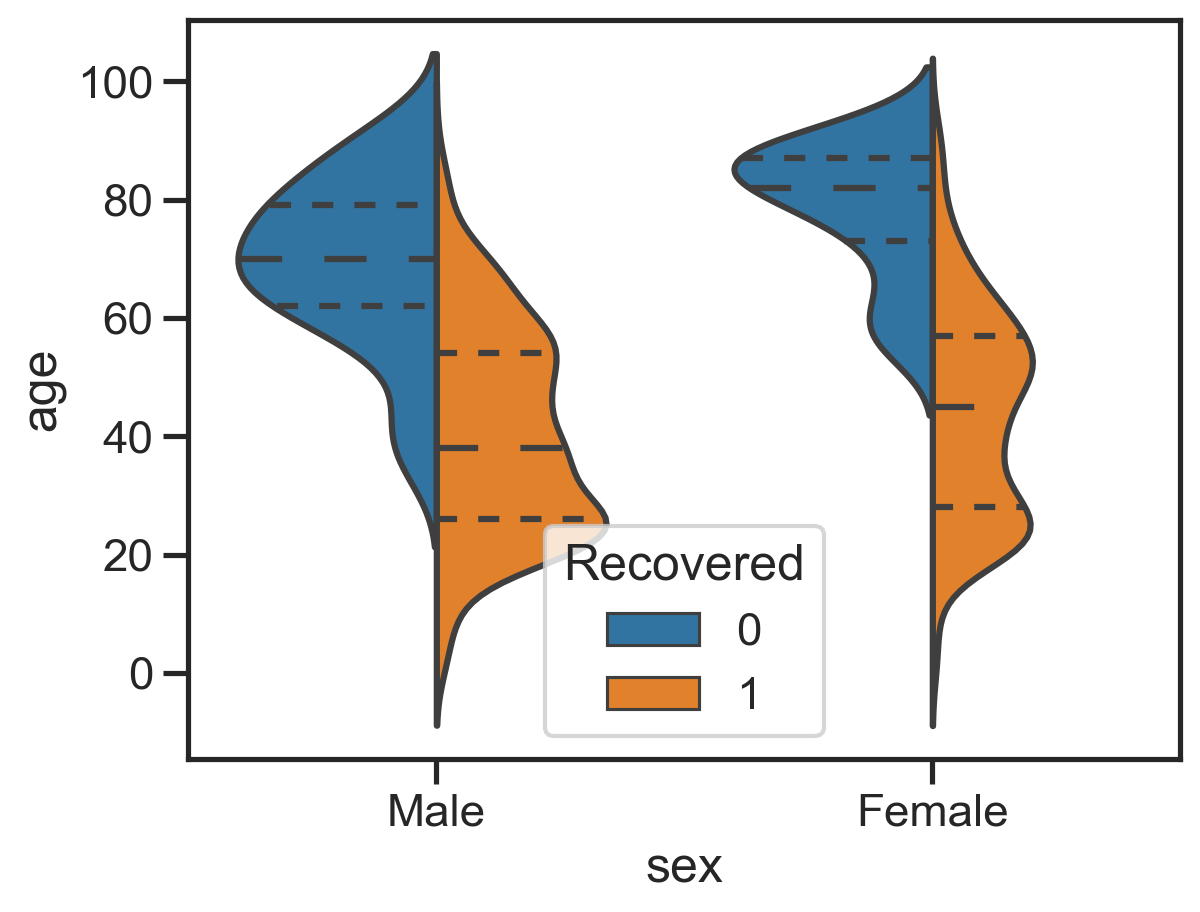

In [8]:
ax = sns.violinplot(data=df, x="sex", y="age", hue="recovered", split=True, inner="quart")
ax.set_xticklabels(['Male', 'Female'])
ax.legend(loc='lower center', title='Recovered');

From this it seems that age has a strong effect on recovery, whereas the role of sex is less clear.

How do we continue?

# Logistic regression

Let's try and use logistic regression to clear this up (if we can).
How does it work?

We briefly mentioned that when predicting integer values the normal distribution, and hence the *normal linear model*, is not be the best model, and demonstrated that a [GLM](https://en.wikipedia.org/wiki/Generalized_linear_model) with a Poisson distribution and an log link function intead of a normal distribution performed better.
We will do a similar trick here.

We first use a linear model (as we did before) to predict the **log-odds** for survival.

Odds here is actually short for odds-ratio (OR), which is just the ratio of the probability that something happens and the probability that it does not happen:
$$
OR = 
\frac{P(\text{Survived})}{P(\text{Died})}
$$
so when the odds-ratio is 1, both events are as likley, and when it is >1 (<1) survival (death) is more likely.

We use the odds-ratio instead of the probability itself, because it is a value between $-\infty$ and $\infty$, rather then between 0 and 1, which is important both for mathematical formality, as the linear model is unbounded, and for interpretation - the odds can be doubles again and again (2:1 becoming 4:1 becomnig 8:1...) whereas the probability cannot (what is the double of 75%?).

The log-odds, which we mark as $z$, is the natural logarithm of the odds ratio.
$$
z = 
\log{\frac{P(\text{Survived})}{P(\text{Died})}}
$$
Why use the log-odds? Because (i) it is more mathematically convinient, as log-odds is symmetric in the probability, whereas odds is not, and (ii) it is easier to interpret, as we will see below.

So to use a linear model for predicting the log-odds, we have $m$ features, $x_1, x_2, \ldots, x_m$, and we try to estimate coefficients $\mathbf{W} = (b, a_1, \ldots, a_m)$ such that
$$
z = b + a_1 x_1 + \ldots + a_m x_m
$$
or 
$$
z = \mathbf{X} \cdot \mathbf{W}
$$
gives us a good prediction of the true log-odds.

From the log-odds we can find the probability for the event to occur using the *logisitic* (hence the name of the method!) or the *expit* function (same function, different name):
$$
P(\text{Survived}) = expit(z) = \frac{1}{1+e^{-z}}
$$

In [9]:
def logodds(X, W, b):
    Z = X @ W + b
    return Z

In [64]:
W = np.ones(X.shape[1])
b = 1
print(logodds(X, W, b)[:5])

[67.5 55.5 38.5 37.5 58.5]


# Maximum likelihood

Now we want to find suitable $a_i$ such that we make a good prediction. 
We'll use *maximum likelihood* again.

Given data $(x, y)$ where $x = (x_1, \ldots, x_m)$ are some numbers and $y$ is either 0 or 1, the logistic model provides us an estimate $\widehat y$

$$
\widehat{y} = P(y=1)=\frac{1}{1+e^{-z}} = \frac{1}{1+e^{-b -a_1 x_1 - \ldots -a_m x_m}}
$$

The likelihood of this model is

$$
\mathcal{L}(b, a_1, \ldots, a_m \mid x_1, \ldots, x_m, y) = 
P(y \mid b, a_1, \ldots, a_m, x_1, \ldots, x_m) = 
\cases{
    \widehat{y}, & y=1 \\
    1-\widehat{y}, & y=0
}
$$

If we have many $(x,y)$ pairs, and we will **assume that each pair is independent** (which maybe we can't always do, and specifically in the Titanic case we probably shouldn't do, but ok) then the joint likelihood of all the pairs is just the product of all the pair likelihoods: the product is used because the joint probability of independent events occuring is the product of their occurence probabilities.
Writing the set of $x$s as $X$ and the corresponding set of $y$s as $Y$, and because $y$ are either 0 or 1,

$$
\mathcal{L}(b, a_1, \ldots, a_m \mid X, Y) = 
\prod_{i} {(\widehat{y}_i)^{y_i} \; (1-\widehat{y}_i) ^{1-y_i}}
$$

We'll use the log-likelihood because otherwise we will have to deal with a product of really small numbers; so we take the sum of the log of the likelihood $\mathbf{L}$ of the the $(x, y)$ pairs (sum because the log of products is the sum of logs). The use of log here is not "magic", it's a mathematical convenience. It just happens that "log-likelihood" sounds very impressive.

$$
\log{\mathcal{L}(b, a_1, \ldots, a_m \mid X, Y)} = 
\sum_{i} {y_i \log{\widehat{y}_i} + (1-y_i) \log{(1-\widehat{y}_i)}}
$$

This is very similar to the negative of an information theory function called [*cross entropy*](https://en.wikipedia.org/wiki/Cross_entropy), and we usually average it over all the samples so that we can compare cross entropies between datasets of different size:

$$
\mathbf{J}(b. a_1, \ldots, a_m, X, Y) = -\frac{1}{n} \log{\mathcal{L}(b, a_1, \ldots, a_m \mid X, Y)}
$$

where $n$ is the number of samples in $X,Y$.

### Numerical stability

Due to numerical issues when using very small or very large numbers, we should play around with the definition a little bit to find an expression that we can calculate with good numerical stability.

Note that
$$
\log{\widehat{y}} = -\log{\Big(1 + e^{-z}\Big)}  = -\log{\Big(1 + e^{-z}\Big)} \\
\log{(1-\widehat{y})} = -z - \log{\Big(1 + e^{-z}\Big)}
$$
and therefore
$$
y \log{\widehat{y}} + (1-y) \log{(1-\widehat{y})} = \\
-y \log{\Big(1 + e^{-z}\Big)} + (1-y)\Big(-z - \log{\Big(1 + e^{-z}\Big)}\Big) = \\
(1-y)z - \log{\Big(1 + e^{-z}\Big)}
$$

Finally,
$$
\log{\mathcal{L}(b, a_1, \ldots, a_m \mid X, Y)} = 
\sum_{(x,y) \in (X,Y)} {-z (1-y) - \log{\Big(1 + e^{-z}\Big)}},
$$
where $z=\text{log-odds} = a_1 x_1 + \ldots + a_n x_n$.

In [11]:
def cross_entropy(X, Y, W, b):
    Z = logodds(X, W, b)
    logliks = -Z * (1 - Y) - np.log(1 + np.exp(-Z))
    return -logliks.mean()

In [12]:
cross_entropy(X, Y, W, b)

2.894007361893733

# Gradient descent and the chain rule

Now we can minimize the cross entropy using gradient descent.
We need to calculate the derivative of the cross entropy with regards to $a_i$.
We will use the [chain rule](https://en.wikipedia.org/wiki/Chain_rule): 

$$
f(g(x))' = f'(g(x)) \cdot g'(x), 
$$

which is easier to write as 

$$
\frac{dx}{dy} = \frac{dx}{dz} \cdot \frac{dz}{dy}
$$

because then we can eliminate fractions as if these were fractions and not [infinitesimals](https://en.wikipedia.org/wiki/Infinitesimal).

Remember that $z=\text{log-odds} = a_0 + a_1 x_1 + \ldots + a_m x_m$ and $\mathbf{J}$ is the cross entropy function which we want to minimize.

Then 
$$
\frac{\partial \mathbf{J}}{\partial a_k} = 
\frac{\partial \mathbf{J}}{\partial \widehat y} \cdot \frac{\partial \widehat y}{\partial z} \cdot \frac{\partial z}{\partial a_k}
$$

The easiest one is:

$$
\frac{\partial z}{\partial a_k} = x_k
$$

The derivative of the logistic function is (you can verify later):

$$
\frac{\partial \widehat y}{\partial z} = \widehat y ( 1-\widehat y )
$$

Next, because $\frac{d}{dx} log(x) = \frac{1}{x}$ (again, you can verify this),

$$
\frac{\partial \mathbf{J}}{\partial \widehat y} = 
- \frac{\partial}{\partial \widehat y} \big(y \log{\widehat{y}} + (1-y) \log{(1-\widehat{y})}\big) = \\
-y \cdot \frac{1}{\widehat y} + (1-y) \cdot \frac{1}{1-\widehat y} = \\
\frac{\widehat y - y}{\widehat y ( 1 - \widehat y)}
$$

Putting it all together,
$$
\frac{\partial \mathbf{J}}{\partial a_k} = 
\frac{\partial \mathbf{J}}{\partial \widehat y} \cdot \frac{\partial \widehat y}{\partial z} \cdot \frac{\partial z}{\partial a_k} = \\
\frac{\widehat y - y}{\widehat y ( 1 - \widehat y)} \cdot \widehat y ( 1-\widehat y ) \cdot x_k = \\
(\widehat y - y) \cdot x_k
$$

which you have to admit is pretty cool: this is the residual (i.e. difference between the predicted and oberverd probabilities, $\widehat y - y$), so 0 when you got it right and 1 or -1 when you got it completely wrong, multiplied by the stength of the signal, so that strong signals (large $x_k$) have a stonger gradient and stonger effect on the result.

This was the gradient for a single sample. We average it over all samples to get a good estimate of the "real gradient" (law of large numbers etc.).

Our implementation of the `gradient_descent` function, similar to the one we had in a previous session, returns updated values for the coefficients `W` and the bias (intercept) `b` based on one iteration of the gradient descent algorithm.

In [29]:
def gradient(X, Y, W, b):
    Yhat = expit(logodds(X, W, b))
    δ = Yhat - Y
    dW = X.T @ δ / δ.shape[0]
    db = δ.mean()
    assert dW.shape == W.shape
    return dW, db

def gradient_descent(X, Y, W, b, η=0.01):
    dW, db = gradient(X, Y, W, b)
    return W - η * dW, b - η * db

When your solution is ready, comment out the first line of the next cell and run it.

In [30]:
W, b = gradient_descent(X, Y, W, b)
print(W)
print(b)

[1.00006441 0.97178336 1.00000027 0.99971903 0.99989209 1.00000074]
0.9996121232787294


# Fitting the logistic model

Fitting the model is done in much the same way as we did with the linear model - just have to choose initial coefficeints, different stopping condition, and adjust to the API of the new `gradient_descent` function.

This time we stop when the difference in cross entropy between two iterations is smaller than some value ($10^{-4}$).

In [113]:
def logistic_model(X, Y, W=None, b=1, iters=100000, PRINT=True):
    if W is None:
        W = np.zeros(X.shape[1])
    W = np.array(W)
    for t in range(iters+1):
        W, b = gradient_descent(X, Y, W, b)
        if PRINT and t % (iters//10) == 0:
            J = cross_entropy(X, Y, W, b)
            print("{}: J={:.6f}, W={}, b={:.4f}".format(t, J, W, b))        
    return W, b

In [114]:
%%time
W, b = logistic_model(X, Y)
print(W, b)

0: J=0.312145, W=[ 1.43800325e-04  8.89647861e-02  5.32078352e-04  1.50644471e-03
 -3.65667992e-05  2.96270900e-04], b=1.0023
10000: J=0.125669, W=[ 0.4433381  -0.02809548  1.16874682  1.00483198 -0.63414936  0.80558626], b=3.3450
20000: J=0.107598, W=[ 0.66582638 -0.04754591  1.74899088  1.18198126 -0.88733436  1.31210868], b=4.3557
30000: J=0.100342, W=[ 0.80995767 -0.05868672  2.12187087  1.23821716 -1.00364344  1.65166771], b=5.0081
40000: J=0.096502, W=[ 0.91288991 -0.06636308  2.39383946  1.26042331 -1.06966815  1.90236577], b=5.4870
50000: J=0.094169, W=[ 0.99061786 -0.07211816  2.60686447  1.26930258 -1.11488704  2.09958982], b=5.8609
60000: J=0.092630, W=[ 1.05157521 -0.07664108  2.78141862  1.27149413 -1.15061785  2.26150464], b=6.1638
70000: J=0.091555, W=[ 1.10071733 -0.08030321  2.92892324  1.26963271 -1.18162518  2.39848164], b=6.4154
80000: J=0.090773, W=[ 1.14117003 -0.08332996  3.05637184  1.26498039 -1.21004937  2.51694383], b=6.6282
90000: J=0.090186, W=[ 1.17501309 

Of course, there are optimization algorithms that are faster than gradient descent - but they might not be suitable for any problem.

In [112]:
%%time
min_result = scipy.optimize.minimize(
    fun=lambda θ: cross_entropy(X, Y, θ[:W.size], θ[-1]),
    x0=np.ones(X.shape[1]+1),
    jac=lambda θ: np.append(*gradient(X, Y, θ[:W.size], θ[-1])),
    # BFGS 28.7 ms ± 4.71 ms, L-BFGS-B 24.1 ms ± 4.59 ms, TNC 16.1 ms ± 3.71 ms, SLSQP 21.4 ms ± 4.96 ms
    method='TNC' 
)
assert min_result.success, min_result.message
print(min_result.x, min_result.fun)

[ 1.45220378 -0.10636561 13.0522182   0.49213882 -2.22943304  8.82715509
  9.02271324] 0.08698445502051798
CPU times: user 183 ms, sys: 18.1 ms, total: 201 ms
Wall time: 31.7 ms


Anyway, let's inspect with the gradient descent results:

In [115]:
print("Odds-ratios:")
print("bias:\t{:.3f}".format(np.exp(b)))
for i, var in enumerate(var_names[1:]):
    print("{}:\t{:.3f}".format(var, np.exp(W[i])))

Odds-ratios:
bias:	1063.441
sex:	3.332
age:	0.916
Hong Kong:	26.260
South Korea:	3.490
Philippines:	0.283
Singapore:	15.089


We can interpret these results as follows:
- a baby with no country or sex ($X=0$) will likely survive.
- Females are 3-fold more likely to survive
- Every year of age reduces survival by about 8%
- The Philippines had a much lower survival probability compared to to other countries.

## Model prediction

Our model outputs *probabilities*, and we need to convert these to classes. 
We will just decide that if the predicted survival probability is 0.5 then that person survived.

A good score for a classification problem is the *accuracy*, which tells us the fraction of cases in which our model agrees with the truth.

In [116]:
Yhat = expit(logodds(X, W, b))
accuracy = ((Yhat>0.5) == Y).mean()

print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 96.72%


# Scikit-learn

Now we fit a logistic model to the data. 
We will use **Scikit-learn** this time: specifically, the `sklearn.linear_model.LogisticRegression` model.

In [117]:
model = LogisticRegression(penalty=None, fit_intercept=True) # by default, scikit-learn uses l2 penalty
model.fit(X, Y)

LogisticRegression(penalty=None)

Here are the effects of the features, using the model coefficients.

In [118]:
print("{:<10}\t{:>11.4f}".format("intercept", np.exp(model.intercept_)[0]))
for var, coef in zip(var_names[1:], np.exp(model.coef_).ravel()):
    print("{:<10}\t{:>11.4f}".format(var, coef))

intercept 	2205127.8616
sex       	     4.2723
age       	     0.8991
Hong Kong 	778622.7999
South Korea	     0.0061
Philippines	     0.0004
Singapore 	1138893.9663


We see that:
- intercept: for a baby with indeterminate sex and country, the death rate is 1 to 2.2 million
- females are about 4.3 times more likely to survive,
- age reduces survival by ~10% per year
- Hong Kong and Singapore are much safer, but this may be due to the effect that we have no data about deceased there.

## Classification threshold

To find a good threshold for classification, lets look at the historgram of probability for death, applied to recovered (blue) and deceased (red) cases.

Threshold: 0.06


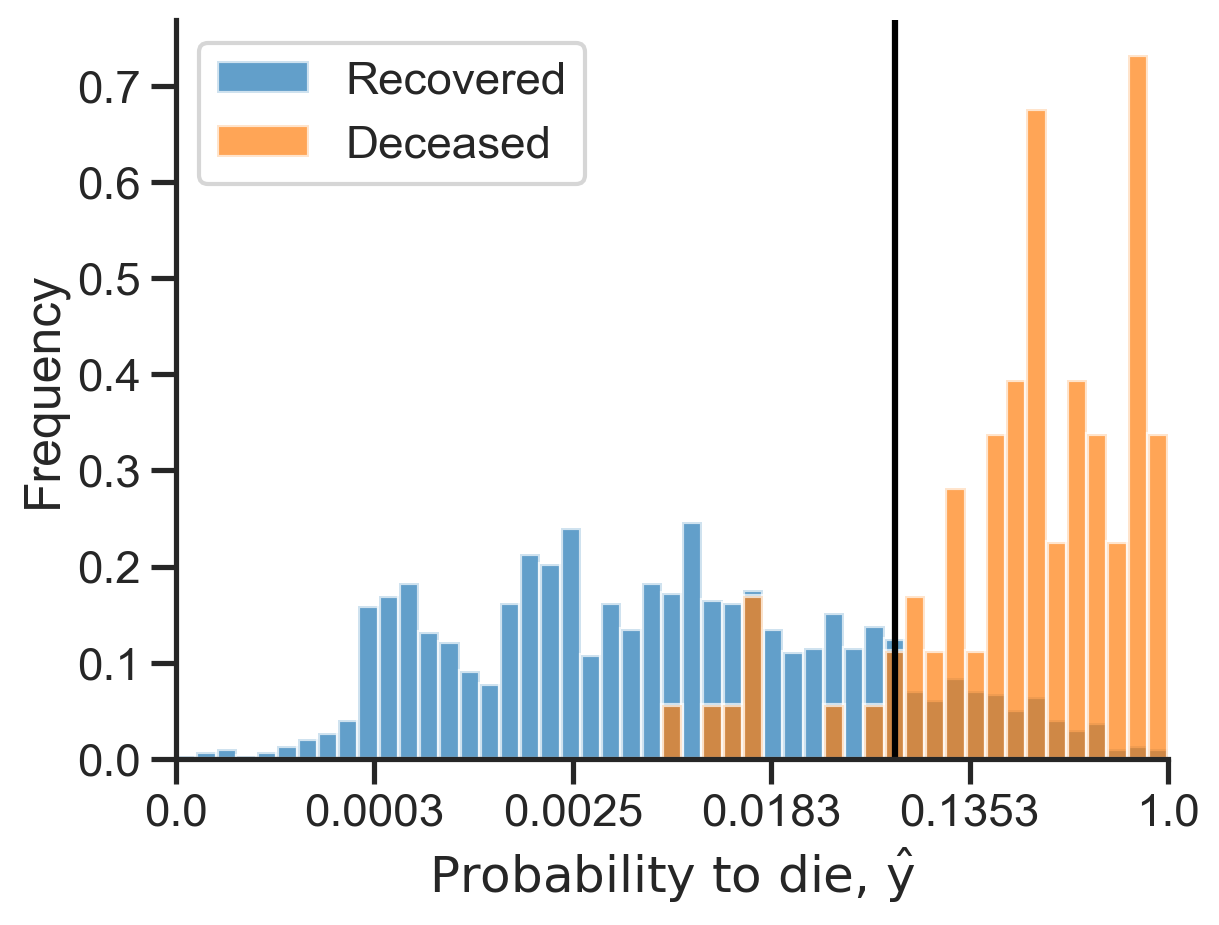

In [120]:
logPdeceased = model.predict_log_proba(X)[:,0] # probabilities are pretty low so we use log-probabilities

bins = np.linspace(-10, 0, 50)
plt.hist(logPdeceased[Y==1], bins=bins,density=True, alpha=0.7, label='Recovered');
plt.hist(logPdeceased[Y==0], bins=bins,density=True, alpha=0.7, label='Deceased')
plt.xlabel(r'Probability to die, $\hat{y}$')
plt.ylabel('Frequency')
xticks = plt.xticks()[0]
plt.xticks(xticks, np.round(np.exp(xticks), 4))
plt.xlim(bins.min(), bins.max())
plt.axvline(-2.75, color='k')
print("Threshold: {:.2f}".format(np.exp(-2.75)))
plt.legend()
sns.despine()

The threshold we pick (i.e. 0.06) can balance between the probability to give an incorrect positive answer and the probability to give a correct positive answer.
These are called the false-positive rate and true-positive rates.

You might consider that it is preferable to sometimes tell someone they are not going to survive and should remain under care, when they are actually going to survive without care, rather than sometimes telling people they are healthy enough to leave the hospital when they are actually not going to make it and they should remain under supervision.

Let's suppose that a positive answer is "person survived" that is $y=1$ or `truth==1` and use *scikit-learn*'s utility to calculate and plot the [Receiver operating characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve.

An "ideal" model will shoot directly to the top, that is, have maximum TPR for any FPR.
A "random" or "naive" model can be expected to follow the dashed line.

Indeed if we look at the ROC curve, the threshold we choose is right on the "knee" of the curve.

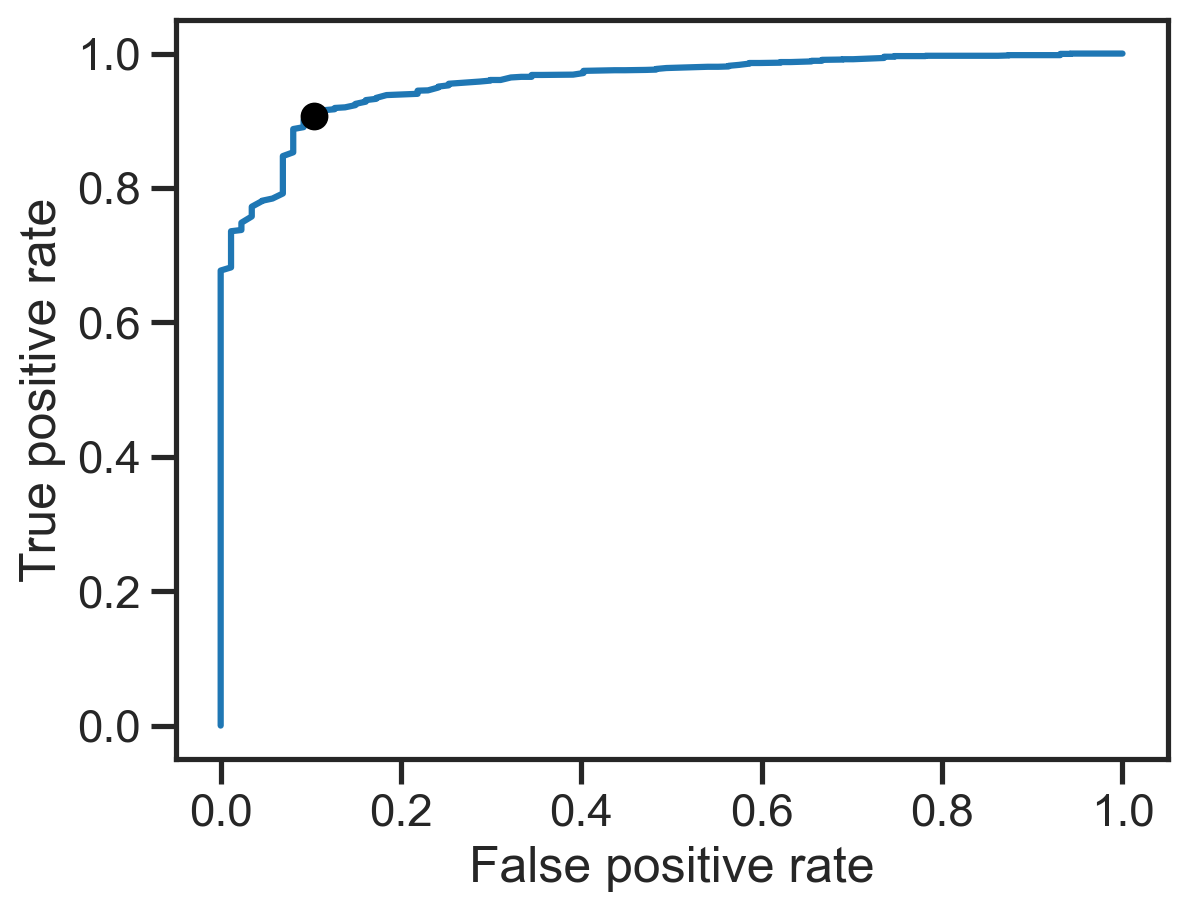

In [121]:
Yhat = model.predict_proba(X)[:,1]

fpr, tpr, thresholds = roc_curve(Y, Yhat)
plt.plot(fpr, tpr)
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
idx = (thresholds < 1-0.06).argmax()
plt.plot(fpr[idx], tpr[idx], 'ok');

We plot the probability to die for each age in each country, separated by sex.

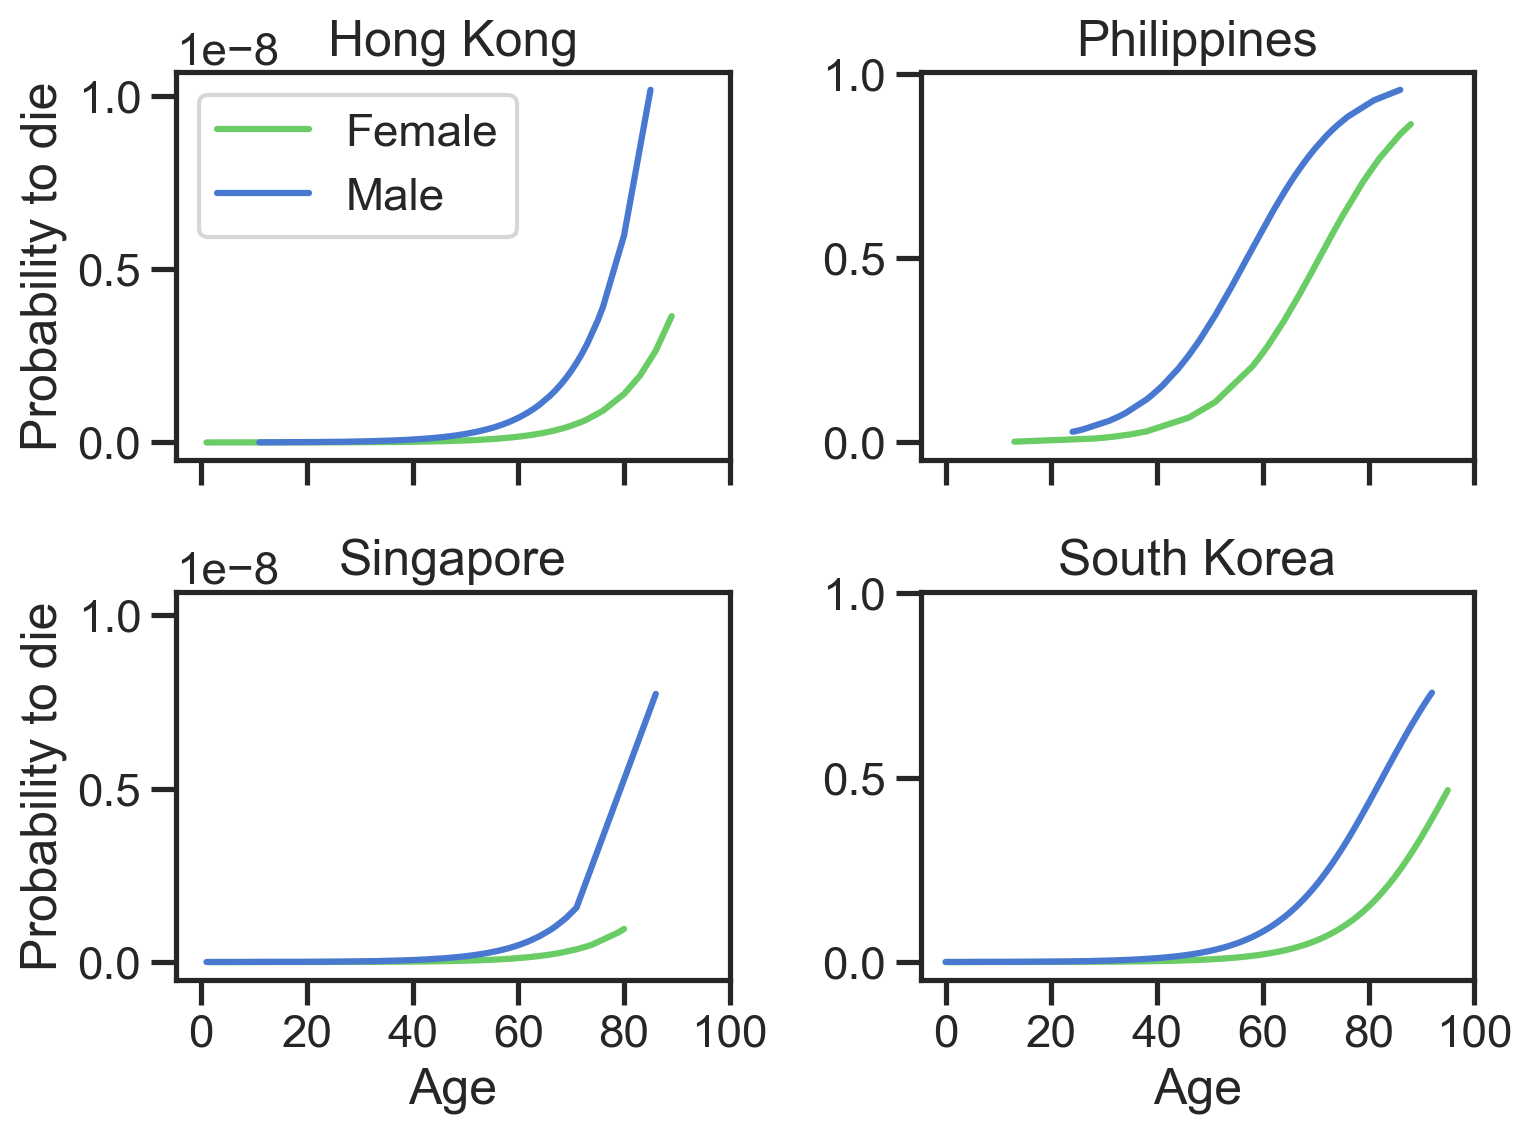

In [122]:
fig, axes = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey='col')
for country, ax in zip(sorted(countries), axes.flat):
    df_ = df[df[country]==1]
    df_ = df_.sort_values('age')
    X_ = df_[var_names[1:]]
    Y_ = df_[var_names[0]]
    Pdie_ = model.predict_proba(X_)[:,0]
    female = df_['sex'] > 0
    ax.plot(X_.loc[female, 'age'], Pdie_[female], '-', color=red, label='Female')
    ax.plot(X_.loc[~female, 'age'], Pdie_[~female], '-', color=blue, label='Male')
    ax.set(title=country)
axes[0,0].legend(loc='upper left')
axes[0,0].set(ylabel='Probability to die')
axes[1,0].set(xlabel='Age', ylabel='Probability to die', xticks=[0, 20, 40, 60, 80, 100])
axes[1,1].set(xlabel='Age', xticks=[0, 20, 40, 60, 80, 100])
fig.tight_layout()

# Bayesian logistic model

This time we will use [bambi](https://bambinos.github.io/bambi/), a high-level Bayesian model-building interface written in Python. It works with the probabilistic programming frameworks PyMC and is designed to make it extremely easy to fit Bayesian mixed-effects models common in biology, social sciences and other disciplines. 

This will save us some work in setting up the model.

In [126]:
import pymc as pm
import arviz as az
import bambi as bmb

print("PyMC", pm.__version__)
print("ArviZ", az.__version__)
print("Bambi", bmb.__version__)

PyMC 5.0.2
ArviZ 0.15.1
Bambi 0.9.3


In [124]:
# create columns without spaces
df['HongKong'] = df['Hong Kong']
df['SouthKorea'] = df['South Korea']

In [125]:
logistic_model = bmb.Model("recovered ~ sex + age + HongKong + SouthKorea + Philippines + Singapore", df, family="bernoulli")
idata = logistic_model.fit(draws=1000, idata_kwargs={"log_likelihood": True})

Modeling the probability that recovered==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, sex, age, HongKong, SouthKorea, Philippines, Singapore]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 131 seconds.


In [129]:
az.to_netcdf(idata, 'idata_logistic_covid.nc')

'idata_logistic_covid.nc'

In [131]:
idata = az.from_netcdf('idata_logistic_covid.nc')

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,13.157,4.011,5.370,20.659,0.107,0.076,1393.0,1684.0,1.0
sex[0.5],1.451,0.291,0.897,1.990,0.005,0.004,2836.0,2666.0,1.0
age,-0.107,0.010,-0.126,-0.090,0.000,0.000,2794.0,2671.0,1.0
HongKong,4.107,4.610,-4.123,12.885,0.117,0.083,1550.0,2211.0,1.0
SouthKorea,-4.322,3.960,-11.589,3.402,0.107,0.076,1376.0,1702.0,1.0
Philippines,-7.068,3.984,-14.776,0.364,0.108,0.077,1368.0,1612.0,1.0
Singapore,5.023,5.589,-5.964,15.015,0.128,0.093,1946.0,2174.0,1.0


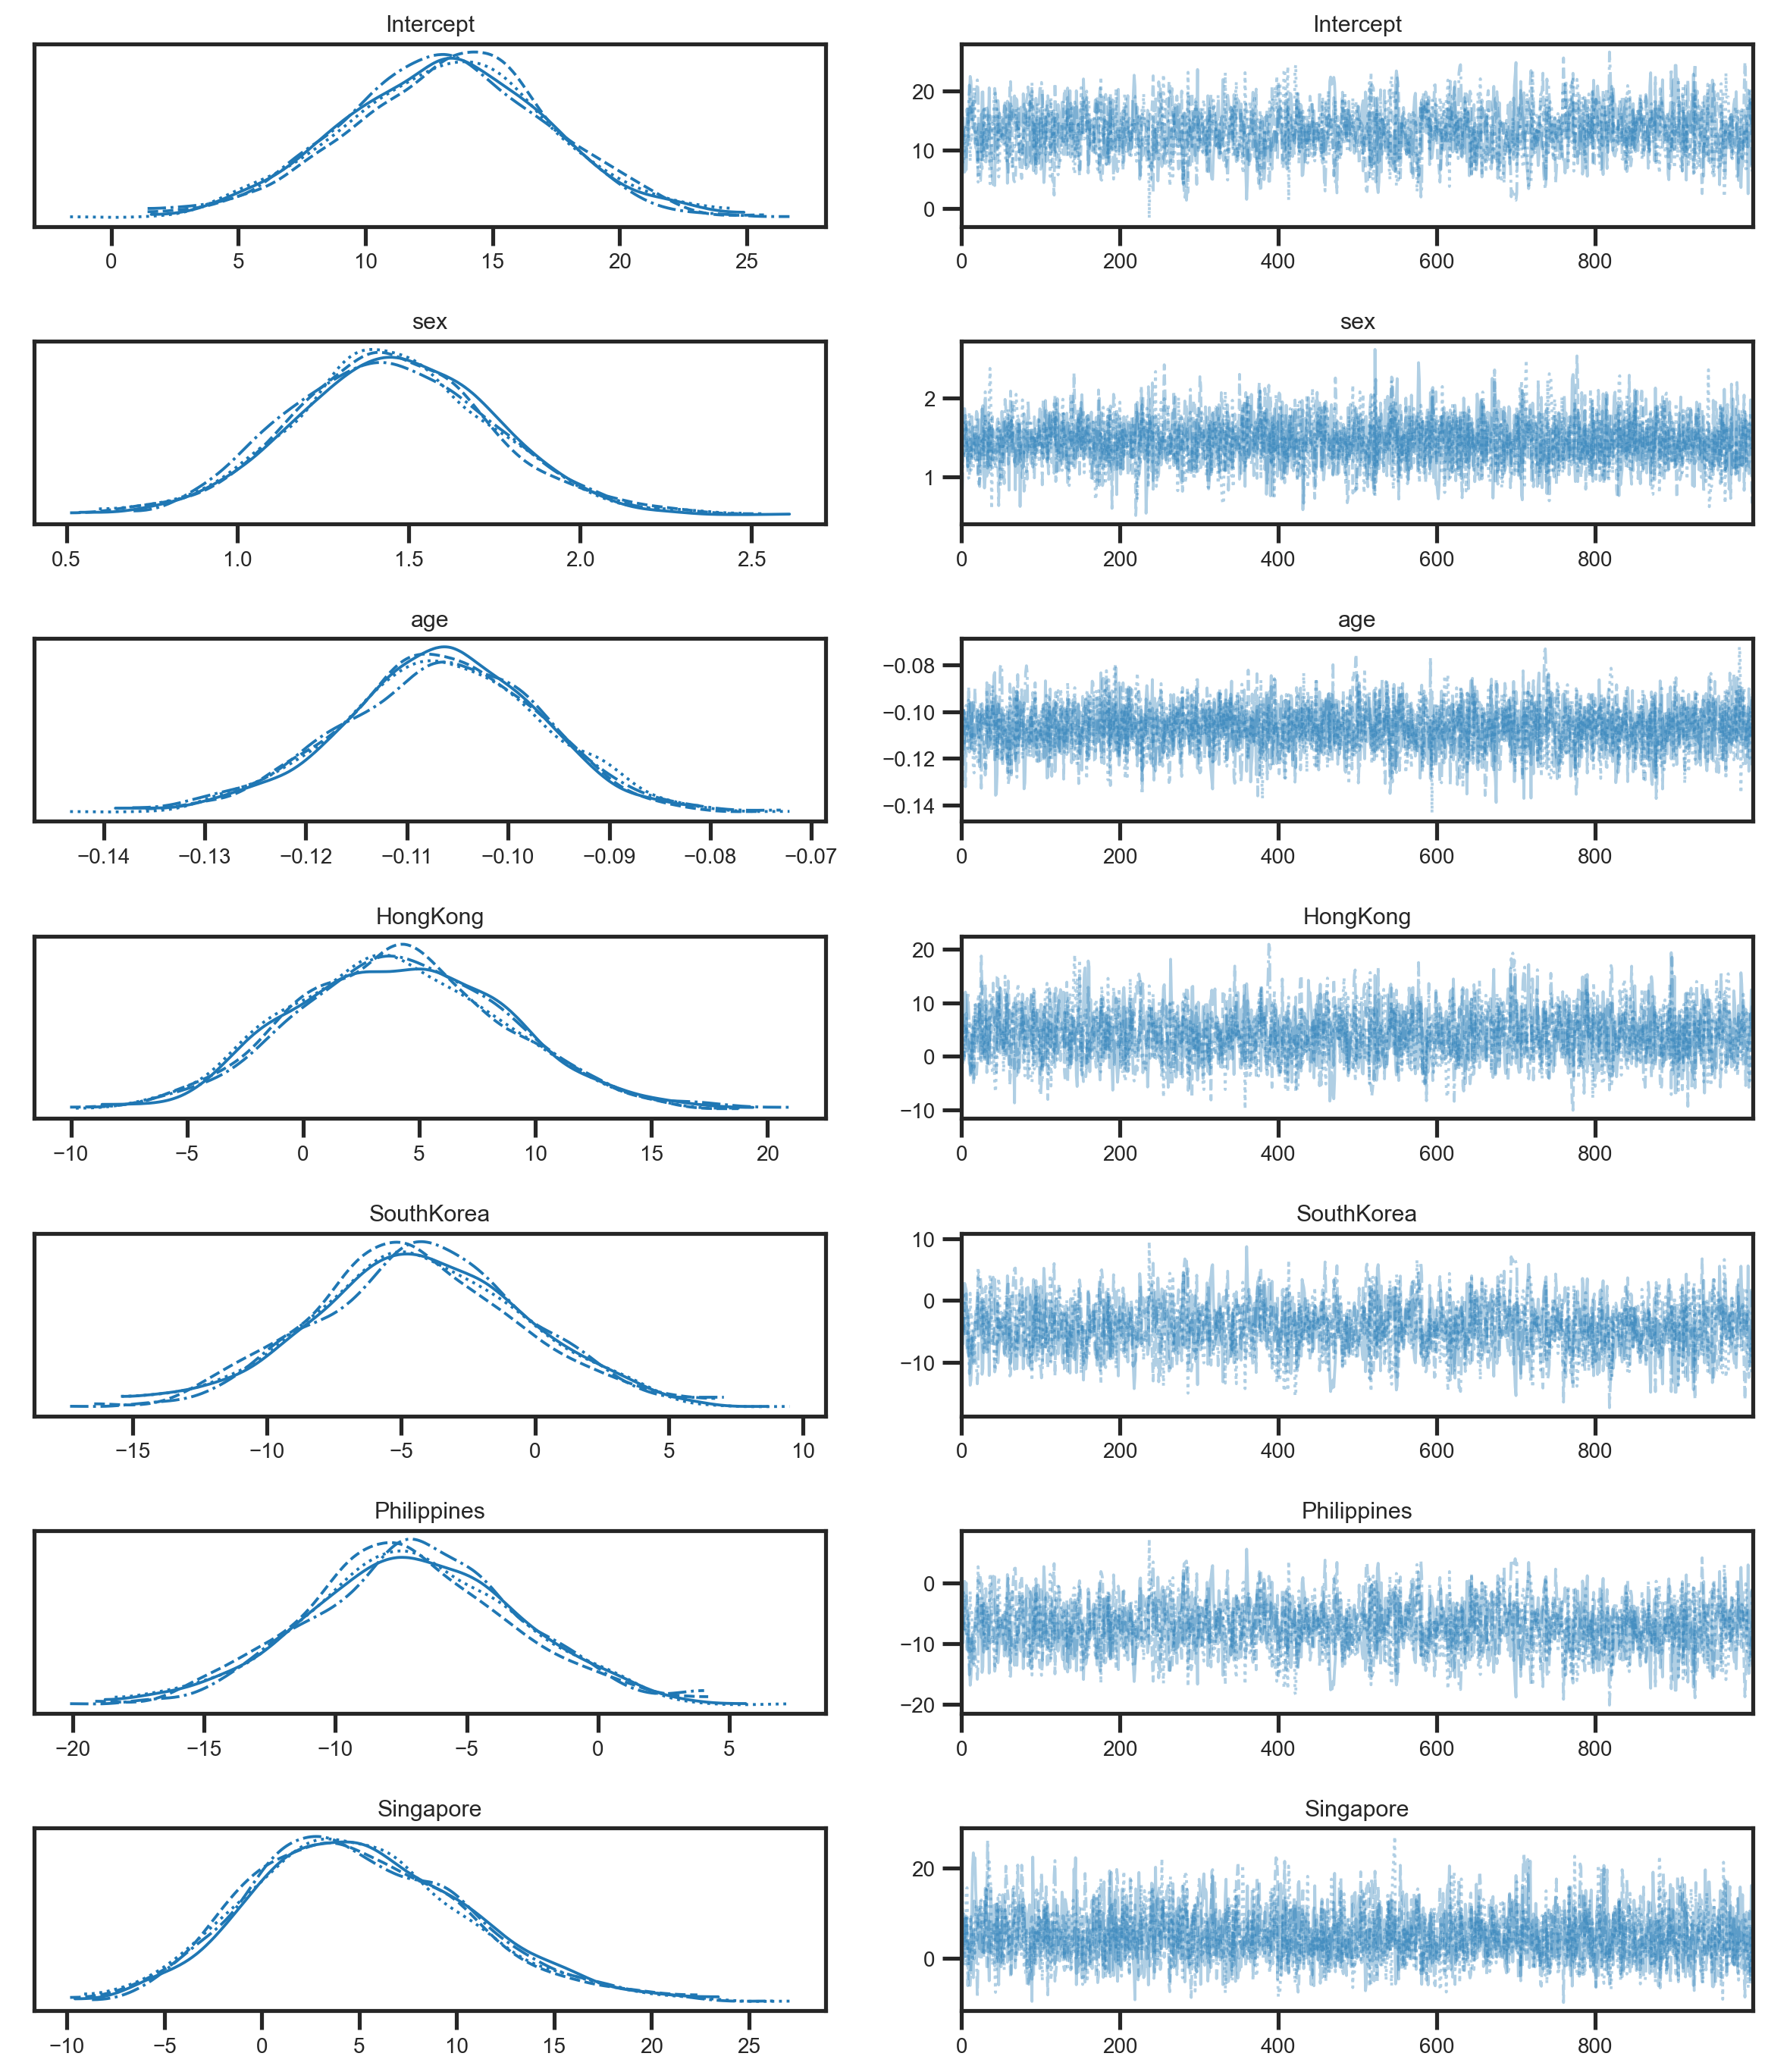

In [132]:
az.plot_trace(idata)
plt.tight_layout()
az.summary(idata)

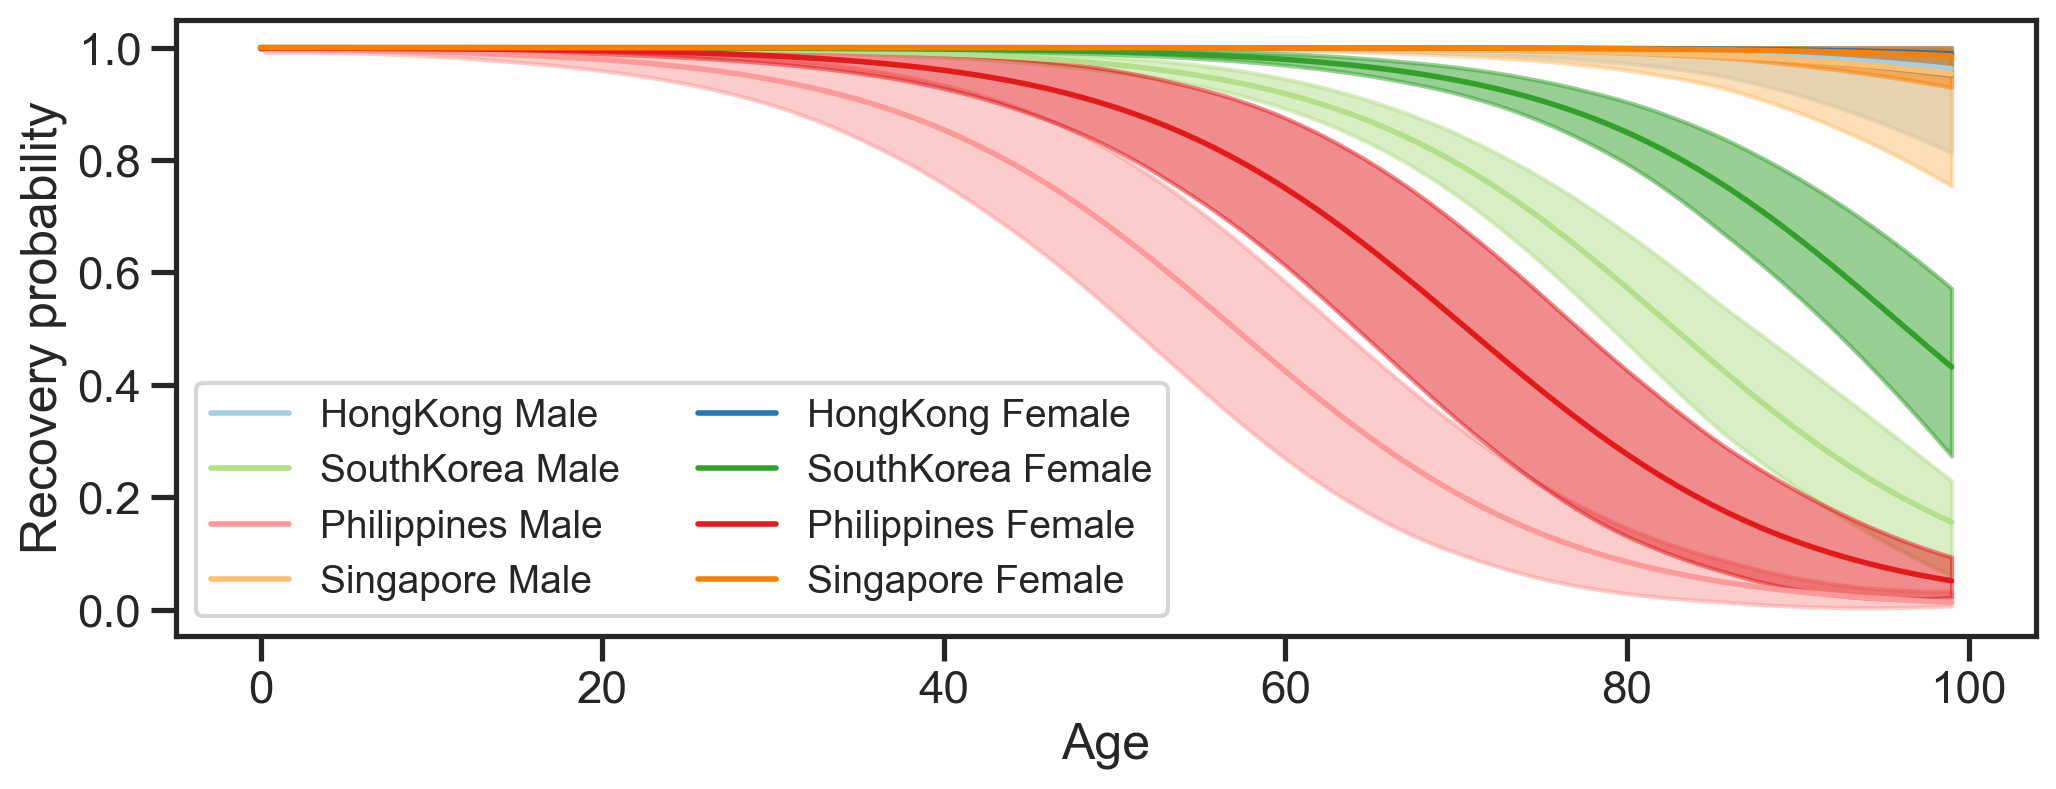

In [190]:
countries = ["HongKong", "SouthKorea", "Philippines", "Singapore"]
sexes = [' Male', ' Female']
colors = sns.color_palette('Paired', 2*len(countries))
age = np.arange(0, 100)
plt.figure(figsize=(12, 4))

for i, sex in enumerate([-0.5, 0.5]):
    base_pred_data = pd.DataFrame({
        'age': age,
        'sex': [sex]*len(age),        
        'HongKong':0,
        'SouthKorea':0,
        'Philippines':0,
        'Singapore':0, 
    })
    for j, country in enumerate(countries):
        pred_data = base_pred_data.copy()
        pred_data[country] = 1
        
        pred_idata = logistic_model.predict(idata, data=pred_data, inplace=False)
        predictions = pred_idata.posterior["recovered_mean"]
        
        plt.plot(age, predictions.mean(['chain', 'draw']), color=colors[2*j+i], lw=2, label=country+sexes[i])
        az.plot_hdi(age, predictions, color=colors[2*j+i])
    
plt.xlabel('Age')
plt.ylabel('Recovery probability')
plt.legend(loc='lower left', ncol=2, fontsize=14);

# References

- Pawitan Y, 2001. *In all likelihood: statistical modelling and inference using likelihood*. **Ch. 6.2**.
- Scikit-learn documentation has a [tutorial](http://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html#classification) using the classical Iris dataset, with examples for other classification methods other than logistic regression.
- [bambi](https://bambinos.github.io/bambi/notebooks/model_comparison.html) logistic regression example including model comparison.

# Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com) and is part of the [_Models in Population Biology_](https://modelpopbiol.yoavram.com/) course at Tel Aviv University.

This work is licensed under a CC BY-NC-SA 4.0 International License.